## Prepare Dataset

In [1]:
import sys
sys.path.insert(1, '../datasets/')
from fasion_mnist import Dataset, DataLoader
from fasion_mnist import image_size, channels, batch_size
dataset = Dataset()
dataloader = DataLoader()

Found cached dataset fashion_mnist (/users/lukemk/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

## Prepare Models

In [2]:
import torch
from torch.optim import Adam
from models import Unet

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

## Hyper-parameters

In [3]:
from pathlib import Path
results_folder = Path("../results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

## Train

In [4]:
from torchvision.utils import save_image
from forward import timesteps
from samplers import sample
from losses import p_losses
from utils import num_to_groups


epochs = 10

for epoch in range(epochs):
    epoch_loss = []
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t, loss_type="huber")
        epoch_loss.append(loss.item())

        # if step % 100 == 0:
        #     print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

        # save generated images
        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(4, batch_size)
            all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0)
            all_images = (all_images + 1) * 0.5
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
    print(f'Loss after epoch {epoch}: {sum(epoch_loss) / len(epoch_loss)}')
    torch.save(model.state_dict(), f'../weights/fasion_mnist_Unet_param_ep{epoch}.pkl')

Loss after epoch 0: 0.1174342342372388
Loss after epoch 1: 0.05483296341193256
Loss after epoch 2: 0.04918785981818049


## Load

In [4]:
# torch.save(model.state_dict(), '../weights/fasion_mnist_Unet_param_ep9.pkl')

In [6]:

model.load_state_dict(torch.load('../weights/fasion_mnist_Unet_param_ep8.pkl'))

<All keys matched successfully>

## Visualize & Eval

In [7]:
from samplers import sample
%matplotlib inline
import matplotlib.pyplot as plt
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)
# print(f'shape of samples: {samples[-1].shape}')


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

shape of samples: (64, 1, 28, 28)


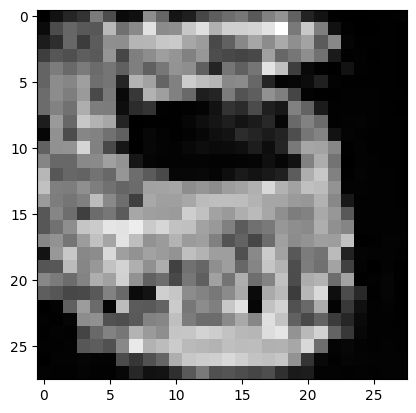

In [12]:

from random import randrange
random_index = randrange(0, 64)
# assert(samples[-1][random_index].shape == channels, image_size, image_size)
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

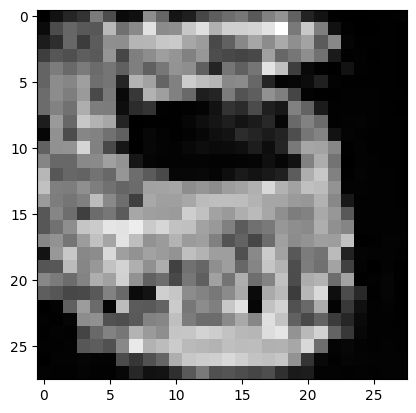

In [13]:
import matplotlib.animation as animation
%matplotlib inline
import matplotlib.pyplot as plt
from random import randrange
from forward import timesteps

# random_index = randrange(0, 64)

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
# print(animate)
animate.save(f'diffusion_{random_index}.gif')
plt.show()